In [1]:
import pickle
import os.path
import argparse
from matplotlib import  pyplot as plt
from utils import *
from attacks import tensorToImg, pgd_delta, pgd_testacc, vis_pgd_attack
from cnnMNIST import CNNMNIST
from resnetCIFAR10 import ResNet18
import random
import utils

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn


dataDir = f'../db'
modelDir = f'./model'
logDir = f'./log'
figDir = f'./fig'
use_cuda = torch.cuda.is_available()
if use_cuda:
    location = 'cuda'
else:
    location = 'cpu'
print(location)

cuda


# MNIST - CNN

In [2]:
torch.manual_seed(1) 
random.seed(1) 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
testset = torchvision.datasets.MNIST(dataDir, train=False,  download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)
nTestSamples, width, height = testset.data.shape
print(f'# test samples:{nTestSamples}')
print(f'per image size: {width}*{height}')

# test samples:10000
per image size: 28*28


In [3]:
net = CNNMNIST()
net.to(location)
criterion = torch.nn.CrossEntropyLoss()
# I trained with torch.nn.DataParallel
net = torch.nn.DataParallel(net)
netname='mnist-cnn'
modelPath = modelDir+ '/best-{}-checkpoint.pth.tar'.format(netname)
checkpoint = torch.load(modelPath, map_location=torch.device(location))
net.load_state_dict(checkpoint['state_dict'])
test_loss, test_accuracy, Ypred = utils._test(net, testloader, criterion, use_cuda, vectorize=False)
    
print(f'For the loaded net: testing loss: {test_loss:5.4f} | testing accuracy:[{test_accuracy:5.4f}]')
print(f"Recorded          : testing loss: {checkpoint['testing_loss_seq'][-1]:5.4f} | testing accuracy:[{checkpoint['testing_accuracy_seq'][-1]:5.4f}]")

For the loaded net: testing loss: 0.0026 | testing accuracy:[0.9873]
Recorded          : testing loss: 0.0026 | testing accuracy:[0.9873]


# PGD Attacks: visualization

In [4]:
# get datasamples
for X,y in testloader:
    images, labels = X.to(location), y.to(location)
    break

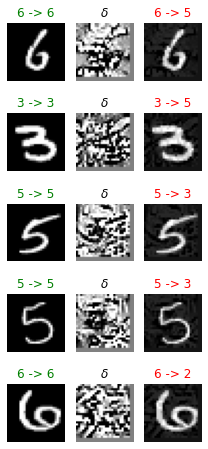

In [5]:
delta = pgd_delta(net, images, labels, criterion, epsilon=0.3, alpha=1e-2, num_iter=40)
vis_pgd_attack(net, images, labels, delta, figtype='gray', inv_normalize= None, M = 5, start=50)

In [6]:
# save figs
for epsilon in [0.0, 0.1, 0.3, 0.5]:
    delta = pgd_delta(net, images, labels, criterion, epsilon=epsilon, alpha=1e-2, num_iter=40)
    vis_pgd_attack(net, images, labels, delta, figtype='gray', 
                   inv_normalize= None, M = 5, start=50, 
                   savename=f'pgd-mnist-cnn-{epsilon}', figDir=figDir)

## PGD attack: measure attack powers

### PGD: iteration 10

In [15]:
acc_lst = []
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
adv_imgs = []
for epsilon in epsilons:
    accuracy, adv_count, adv_examples = pgd_testacc(net, testloader, criterion, epsilon, use_cuda, alpha=1e-2, num_iter=10)
    acc_lst.append(accuracy)
    adv_imgs.append(adv_examples)
    if epsilon != 0.0:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} | # adversarial examples:{adv_count:6d}")
    else:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} ")

epsilon:0.00 | accuracy:0.987 
epsilon:0.10 | accuracy:0.883 | # adversarial examples:  1047
epsilon:0.20 | accuracy:0.883 | # adversarial examples:  1047
epsilon:0.30 | accuracy:0.883 | # adversarial examples:  1047
epsilon:0.40 | accuracy:0.883 | # adversarial examples:  1047
epsilon:0.50 | accuracy:0.883 | # adversarial examples:  1047


### PGD: iteration 25

In [13]:
acc_lst = []
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
adv_imgs = []
for epsilon in epsilons:
    accuracy, adv_count, adv_examples = pgd_testacc(net, testloader, criterion, epsilon, use_cuda, alpha=1e-2, num_iter=25)
    acc_lst.append(accuracy)
    adv_imgs.append(adv_examples)
    if epsilon != 0.0:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} | # adversarial examples:{adv_count:6d}")
    else:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} ")

epsilon:0.00 | accuracy:0.987 
epsilon:0.10 | accuracy:0.857 | # adversarial examples:  1310
epsilon:0.20 | accuracy:0.431 | # adversarial examples:  5572
epsilon:0.30 | accuracy:0.242 | # adversarial examples:  7468
epsilon:0.40 | accuracy:0.242 | # adversarial examples:  7468
epsilon:0.50 | accuracy:0.242 | # adversarial examples:  7468


### PGD: iteration 40

In [6]:
acc_lst = []
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
adv_imgs = []
for epsilon in epsilons:
    accuracy, adv_count, adv_examples = pgd_testacc(net, testloader, criterion, epsilon, use_cuda, alpha=1e-2, num_iter=40)
    acc_lst.append(accuracy)
    adv_imgs.append(adv_examples)
    if epsilon != 0.0:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} | # adversarial examples:{adv_count:6d}")
    else:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} ")

epsilon:0.00 | accuracy:0.987 
epsilon:0.10 | accuracy:0.854 | # adversarial examples:  1344
epsilon:0.20 | accuracy:0.372 | # adversarial examples:  6161
epsilon:0.30 | accuracy:0.037 | # adversarial examples:  9516
epsilon:0.40 | accuracy:0.004 | # adversarial examples:  9848
epsilon:0.50 | accuracy:0.004 | # adversarial examples:  9848


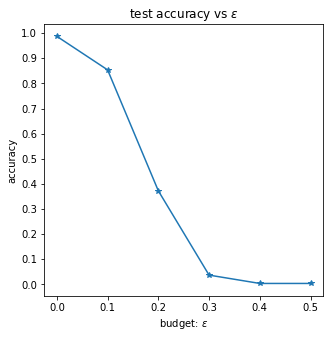

In [7]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, acc_lst, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.title(r"test accuracy vs $\varepsilon$")
plt.xlabel(r"budget: $\varepsilon$")
plt.ylabel("accuracy")
plt.show()

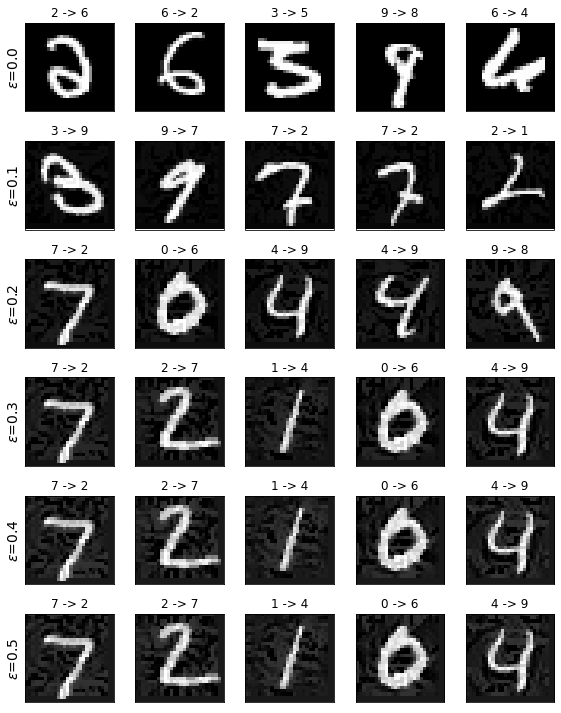

In [8]:
# show adversarial examples
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(adv_imgs[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(adv_imgs[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(r"$\varepsilon$={}".format(epsilons[i]), fontsize=14)
        img,true_label,predicted_label = adv_imgs[i][j]
        plt.title("{} -> {}".format(true_label, predicted_label))
        plt.imshow(img[0], cmap="gray")
plt.tight_layout()
plt.show()

# CIFAR10 - Resnet18 

In [2]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(dataDir, train=False,  download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)
nTestSamples, width, height, channel = testset.data.shape
print(f'# test samples:{nTestSamples}')
print(f'per image size: {width}*{height} | per image channel:{channel}')

# test samples:10000
per image size: 32*32 | per image channel:3


In [3]:
net = ResNet18()
net.to(location)
net = torch.nn.DataParallel(net)
criterion = torch.nn.CrossEntropyLoss()
netname=f'cifar10-resnet'
modelPath = modelDir+ '/best-{}-checkpoint.pth.tar'.format(netname)
checkpoint = torch.load(modelPath, map_location=torch.device(location))
net.load_state_dict(checkpoint['state_dict'])
test_loss, test_accuracy, Ypred = utils._test(net, testloader, criterion, use_cuda, vectorize=False)
print(f'For the loaded net: testing loss: {test_loss:5.4f} | testing accuracy:[{test_accuracy:5.4f}]')
print(f"Recorded          : testing loss: {checkpoint['testing_loss_seq'][-1]:5.4f} | testing accuracy:[{checkpoint['testing_accuracy_seq'][-1]:5.4f}]")

For the loaded net: testing loss: 0.6053 | testing accuracy:[0.9465]
Recorded          : testing loss: 0.6053 | testing accuracy:[0.9465]


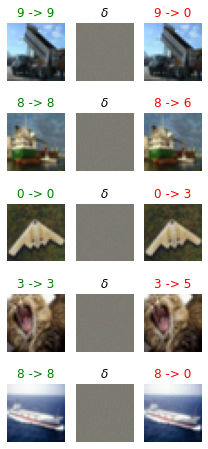

In [15]:
# get datasamples
for X,y in testloader:
    images, labels = X.to(location), y.to(location)
    break
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010])
delta = pgd_delta(net, images, labels, criterion, epsilon=0.3, alpha=1e-2, num_iter=5)
vis_pgd_attack(net, images, labels, delta, figtype='rgb', inv_normalize= inv_normalize, M = 5, start=50)

In [16]:
# save figs
for epsilon in [0.0, 0.1, 0.3, 0.5]:
    delta = pgd_delta(net, images, labels, criterion, epsilon=epsilon, alpha=1e-2, num_iter=5)
    vis_pgd_attack(net, images, labels, delta, figtype='rgb', 
                   inv_normalize=inv_normalize, M = 5, start=50, 
                   savename=f'pgd-cifar10-resnet18-{epsilon}', figDir=figDir)

## PGD attack: measure attack powers

### PGD: iteration 2

In [9]:
acc_lst = []
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
adv_imgs = []
for epsilon in epsilons:
    accuracy, adv_count, adv_examples = pgd_testacc(net, testloader, criterion, epsilon, use_cuda, alpha=1e-2, num_iter=2)
    acc_lst.append(accuracy)
    adv_imgs.append(adv_examples)
    if epsilon != 0.0:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} | # adversarial examples:{adv_count:6d}")
    else:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} ")

epsilon:0.00 | accuracy:0.947 
epsilon:0.10 | accuracy:0.585 | # adversarial examples:  3618
epsilon:0.20 | accuracy:0.585 | # adversarial examples:  3618
epsilon:0.30 | accuracy:0.585 | # adversarial examples:  3618
epsilon:0.40 | accuracy:0.585 | # adversarial examples:  3618
epsilon:0.50 | accuracy:0.585 | # adversarial examples:  3618


### PGD: iteration 3

In [14]:
acc_lst = []
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
adv_imgs = []
for epsilon in epsilons:
    accuracy, adv_count, adv_examples = pgd_testacc(net, testloader, criterion, epsilon, use_cuda, alpha=1e-2, num_iter=3)
    acc_lst.append(accuracy)
    adv_imgs.append(adv_examples)
    if epsilon != 0.0:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} | # adversarial examples:{adv_count:6d}")
    else:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} ")

epsilon:0.00 | accuracy:0.947 
epsilon:0.10 | accuracy:0.440 | # adversarial examples:  5068
epsilon:0.20 | accuracy:0.440 | # adversarial examples:  5068
epsilon:0.30 | accuracy:0.440 | # adversarial examples:  5068
epsilon:0.40 | accuracy:0.440 | # adversarial examples:  5068
epsilon:0.50 | accuracy:0.440 | # adversarial examples:  5068


### PGD: iteration 5

In [10]:
acc_lst = []
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
adv_imgs = []
for epsilon in epsilons:
    accuracy, adv_count, adv_examples = pgd_testacc(net, testloader, criterion, epsilon, use_cuda, alpha=1e-2, num_iter=5)
    acc_lst.append(accuracy)
    adv_imgs.append(adv_examples)
    if epsilon != 0.0:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} | # adversarial examples:{adv_count:6d}")
    else:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} ")

epsilon:0.00 | accuracy:0.947 
epsilon:0.10 | accuracy:0.278 | # adversarial examples:  6693
epsilon:0.20 | accuracy:0.278 | # adversarial examples:  6693
epsilon:0.30 | accuracy:0.278 | # adversarial examples:  6693
epsilon:0.40 | accuracy:0.278 | # adversarial examples:  6693
epsilon:0.50 | accuracy:0.278 | # adversarial examples:  6693


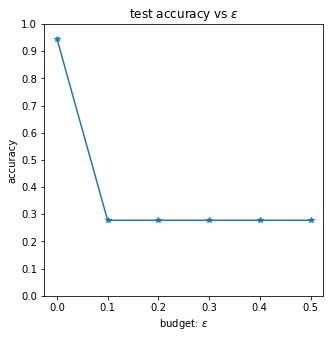

In [11]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, acc_lst, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.title(r"test accuracy vs $\varepsilon$")
plt.xlabel(r"budget: $\varepsilon$")
plt.ylabel("accuracy")
plt.show()

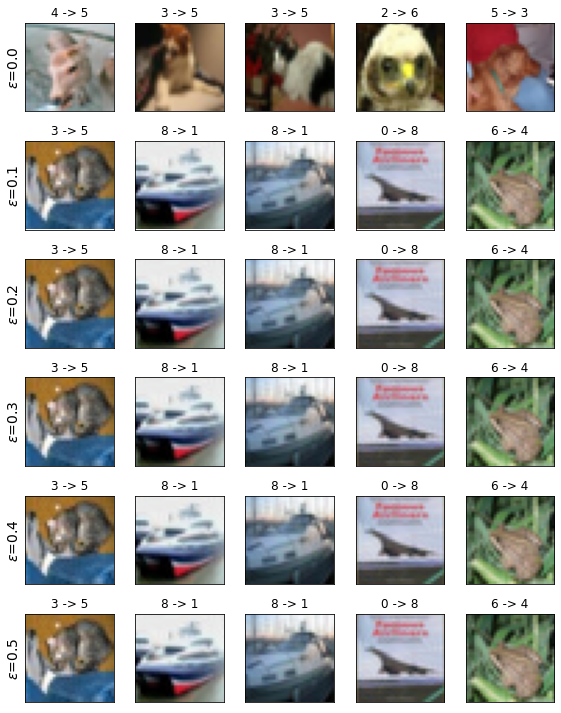

In [13]:
# show adversarial examples
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(adv_imgs[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(adv_imgs[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(r"$\varepsilon$={}".format(epsilons[i]), fontsize=14)
        img,true_label,predicted_label = adv_imgs[i][j]
        plt.title("{} -> {}".format(true_label, predicted_label))
        plt.imshow(tensorToImg(img, inv_normalize))
plt.tight_layout()
plt.show()